In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text
import keras.backend.tensorflow_backend as K
K.set_session
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import shap
import numpy
import sklearn.metrics as skm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-pack

In [2]:
all_data = pd.read_csv('../Jie-Xing-Colab/data/winery_data20200912-v2.csv', 
                            index_col=0,header=0, 
                            encoding = "utf8")
# all_data.head(2)

data = all_data.sample(frac=0.25, random_state=2020)

data.shape

(21380, 14)

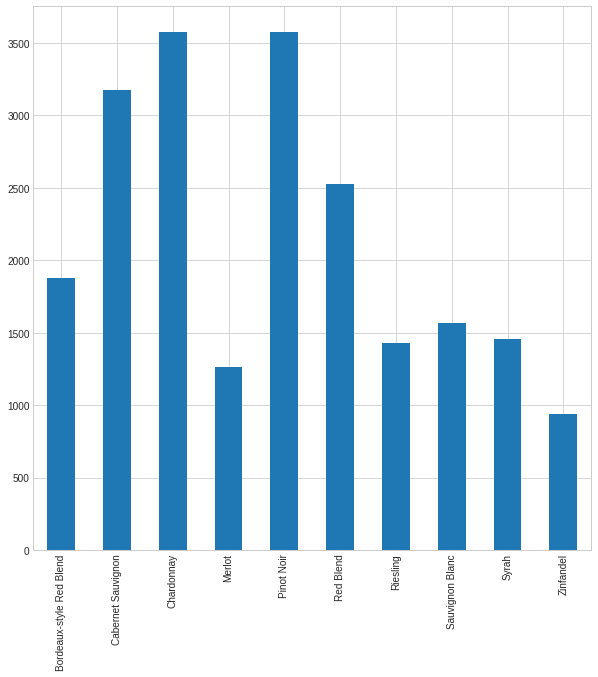

In [3]:
plt.figure(figsize=(10, 10))
data.iloc[:, 1:11].sum(axis = 0, skipna = True).plot(kind='bar');

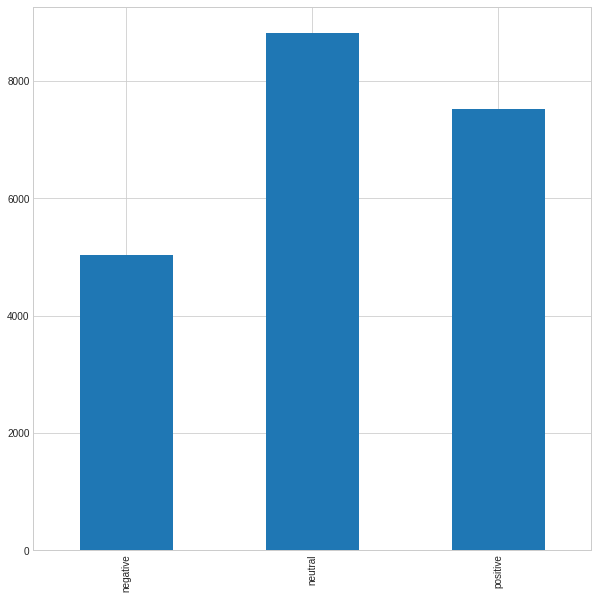

In [4]:
plt.figure(figsize=(10, 10))
data.iloc[:, -3:].sum(axis = 0, skipna = True).plot(kind='bar');

In [5]:
y_df = data.iloc[:, 1:]

tags = list(y_df.columns)
tags

['Bordeaux-style Red Blend',
 'Cabernet Sauvignon',
 'Chardonnay',
 'Merlot',
 'Pinot Noir',
 'Red Blend',
 'Riesling',
 'Sauvignon Blanc',
 'Syrah',
 'Zinfandel',
 'negative',
 'neutral',
 'positive']

In [6]:
Y = y_df.values
Y[:5]

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

# Load Processed Data

In [13]:
import pickle

file_path = './data/we-processed-20200912-v2.pickle'
with open(file_path, 'rb') as pickle_file:
    X_train_pad = pickle.load(pickle_file)
    y_train = pickle.load(pickle_file)
    X_test_pad = pickle.load(pickle_file)
    y_test = pickle.load(pickle_file)
    review_text = pickle.load(pickle_file)

In [14]:
import os
import numpy as np

GLOVE_DIR = '../spam_2019/data/'

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [15]:
VOCAB_SIZE = 20000 #19793
EMBED_DIM = 100
MAX_LENGTH = 150

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(review_text)

In [17]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [18]:
embedding_matrix_pos = np.exp(embedding_matrix)

In [19]:
def globe_emb(train_array, emb_dim=100):
    emb_matrix = []
    for x in train_array:
        embs = []
        embs += [embedding_matrix_pos[i] for i in x]
        embs = np.array(embs)
        X_train_emb0 = embs.mean(axis=0)
#         X_train_emb0 = np.sum(embs,axis=0)    
        emb_matrix.append(X_train_emb0)
    emb_matrix = np.array(emb_matrix)
    return emb_matrix

In [20]:
train_matrix = globe_emb(X_train_pad)
test_matrix = globe_emb(X_test_pad)

# Modeling

In [21]:
num_tags = y_df.shape[1]

In [28]:
batch_size = 32
epochs = 15

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional,Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3)

In [31]:
model = Sequential()
#model.add(Input(shape=(100,)))
model.add(Dense(128, activation='relu', input_shape=(100,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_tags, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 13)                429       
Total params: 89,613
Trainable params: 89,613
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(train_matrix, y_train, batch_size = batch_size ,  validation_split=0.1, 
                    epochs = epochs , callbacks = [learning_rate_reduction, es])

Train on 15393 samples, validate on 1711 samples
Epoch 1/15
15393/15393 [==============================] - 4s 237us/sample - loss: 0.3981 - acc: 0.8391 - val_loss: 0.3881 - val_acc: 0.8462
Epoch 2/15
15393/15393 [==============================] - 3s 215us/sample - loss: 0.3869 - acc: 0.8462 - val_loss: 0.3883 - val_acc: 0.8462
Epoch 3/15
15393/15393 [==============================] - 3s 214us/sample - loss: 0.3865 - acc: 0.8462 - val_loss: 0.3864 - val_acc: 0.8462
Epoch 4/15
15393/15393 [==============================] - 3s 213us/sample - loss: 0.3858 - acc: 0.8462 - val_loss: 0.3830 - val_acc: 0.8465
Epoch 5/15
15393/15393 [==============================] - 3s 218us/sample - loss: 0.3812 - acc: 0.8471 - val_loss: 0.3769 - val_acc: 0.8499
Epoch 6/15
15393/15393 [==============================] - 3s 216us/sample - loss: 0.3780 - acc: 0.8487 - val_loss: 0.3788 - val_acc: 0.8488
Epoch 7/15
15232/15393 [============================>.] - ETA: 0s - loss: 0.3779 - acc: 0.8488
Epoch 00007: Red

# Interpretation

In [34]:
import shap

attrib_data = train_matrix[:5000]
explainer = shap.DeepExplainer(model, attrib_data)
num_explanations = 500
shap_vals = explainer.shap_values(test_matrix[:num_explanations])

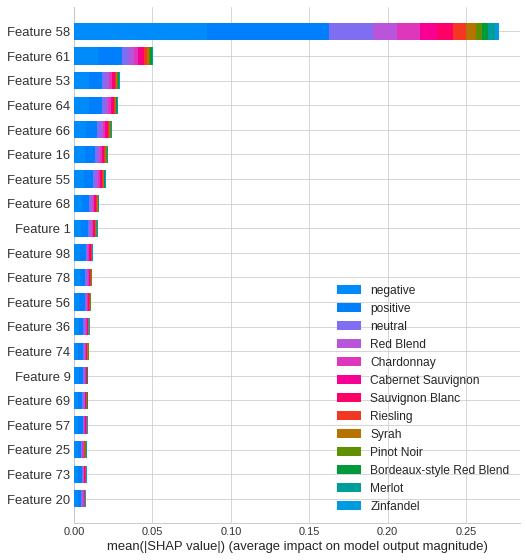

In [35]:
shap.summary_plot(shap_vals, class_names=tags)

Bordeaux-style Red Blend


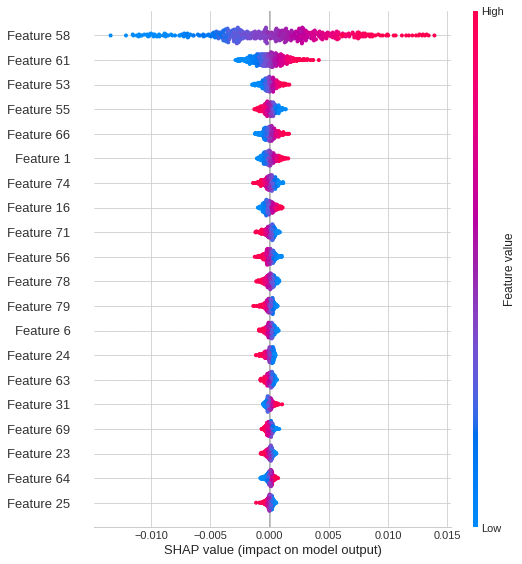

Cabernet Sauvignon


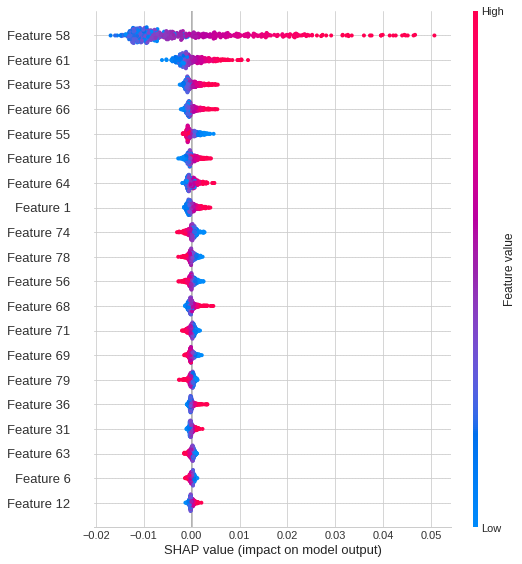

Chardonnay


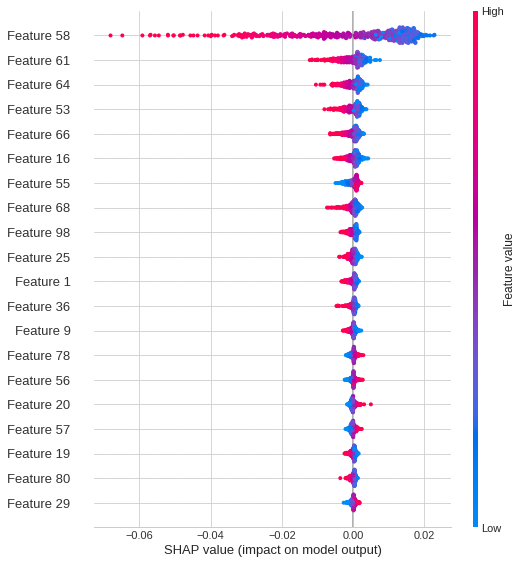

Merlot


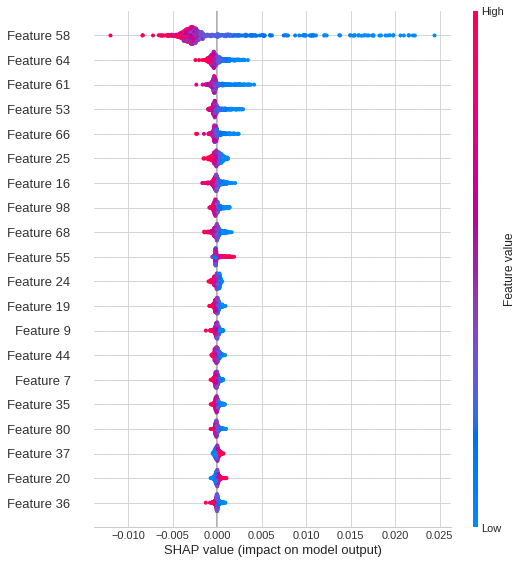

Pinot Noir


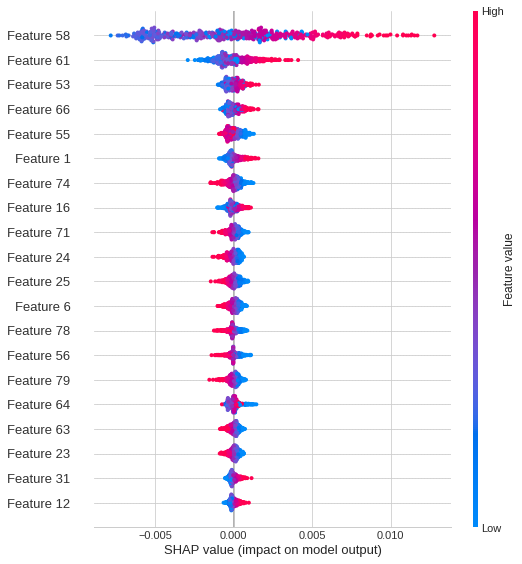

Red Blend


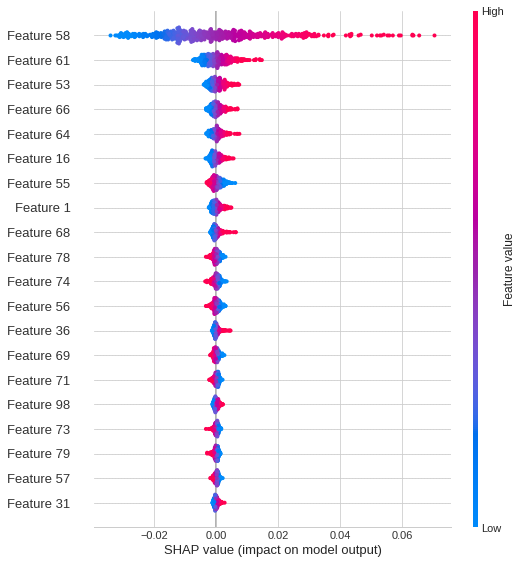

Riesling


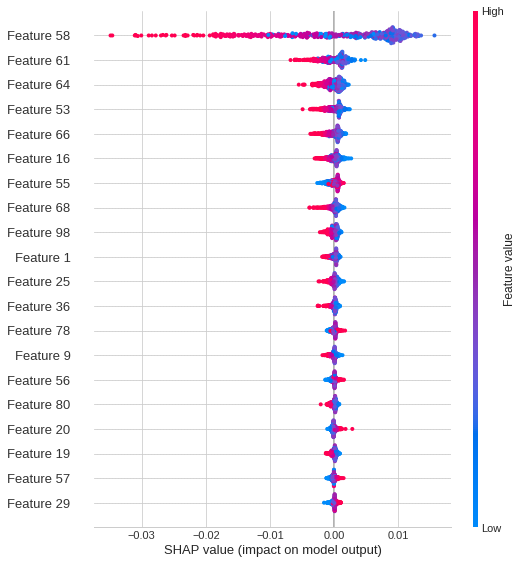

Sauvignon Blanc


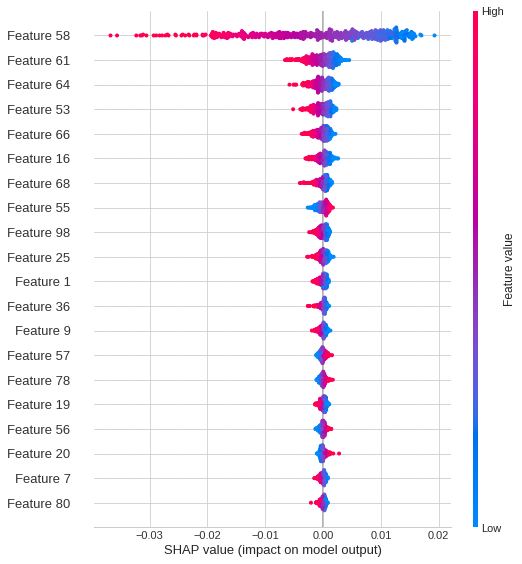

Syrah


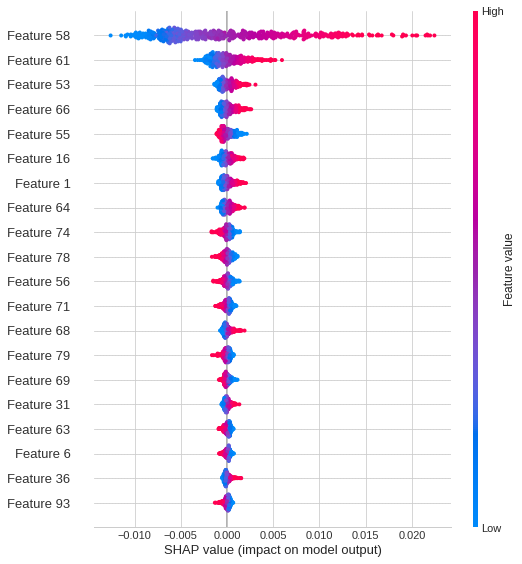

Zinfandel


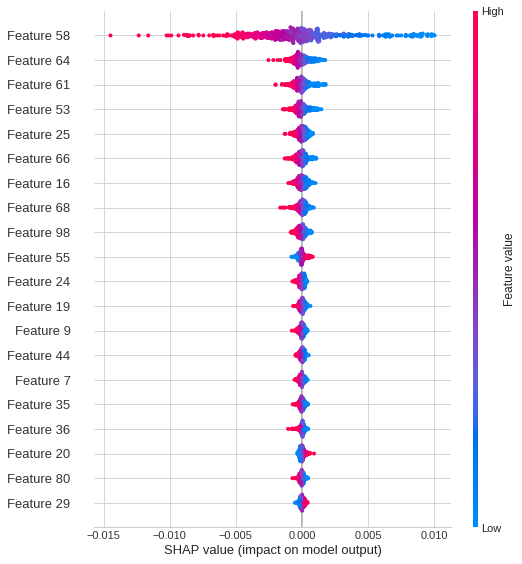

negative


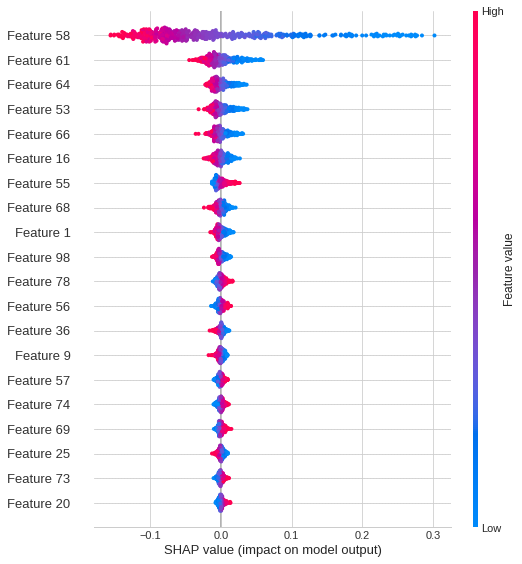

neutral


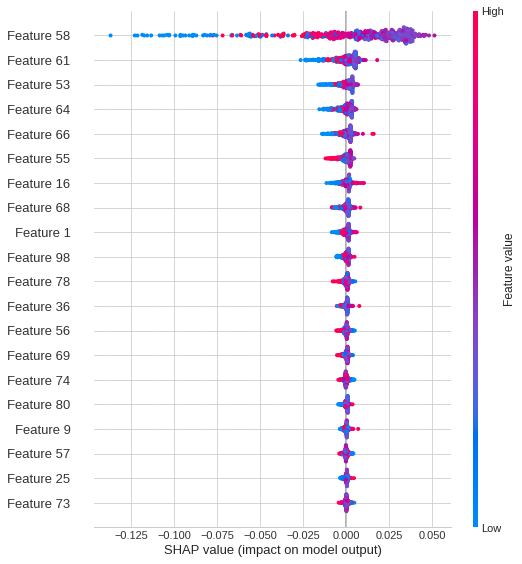

positive


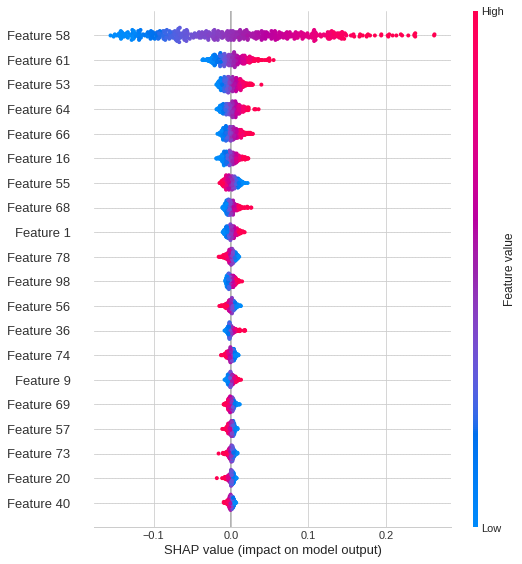

In [39]:
for i in range(13):
    print(y_df.columns[i])
    shap.summary_plot(shap_vals[i], test_matrix[:num_explanations])

In [40]:
shap_vals_arr = np.array(shap_vals)
shap_vals_arr.shape

(13, 500, 100)

In [41]:
shap_vals_global = shap_vals_arr.mean(axis=1)
shap_vals_global.shape

(13, 100)

In [42]:
test_voc = []
for x in X_test_pad[:num_explanations]:
    test_voc.extend(x)
    
test_voc = list(set(test_voc))
len(test_voc)

1926

In [45]:
test_embedding_matrix = []
for t in test_voc:
    if t <= embedding_matrix_pos.shape[1]:
        test_embedding_matrix.append(embedding_matrix_pos[t])
    else:
        test_embedding_matrix.append(np.zeros(100))
test_embedding_matrix = np.array(test_embedding_matrix)
test_embedding_matrix.shape

(1926, 100)

In [46]:
shap_class_word = np.dot(shap_vals_global, test_embedding_matrix.T)
shap_class_word.shape

(13, 1926)

In [47]:
word_lookup = {v:k for k,v in tokenizer.word_index.items()}

In [48]:
for i in range(shap_class_word.shape[0]):
    idx = np.argpartition(shap_class_word[i], -50)[-50:]
    sorted_idx = idx[np.argsort(shap_class_word[i][idx])]
    print(tags[i])
    print([word_lookup[j] for j in sorted_idx])

Bordeaux-style Red Blend
['vineyard', 'acid', 'pepper', 'crisp', 'flavor', 'blend', 'oak', 'mouth', 'bit', 'bright', 'dark', 'wood', 'barrel', 'cola', 'note', 'touch', 'age', 'show', 'feel', 'style', 'green', 'fruit', 'nose', 'drink', 'smooth', 'now', 'wine', 'finish', 'fresh', 'like', 'well', 'clean', 'rich', 'red', 'date', 'there', 'soft', 'firm', 'good', 'give', 'fine', 'person', 'light', 'complex', 'black', 'long', 'make', 'offer', 'full', 'percent']
Cabernet Sauvignon
['crisp', 'pepper', 'nice', 'flavor', 'acid', 'blend', 'oak', 'mouth', 'bit', 'barrel', 'bright', 'cola', 'wood', 'dark', 'note', 'touch', 'age', 'fruit', 'feel', 'show', 'green', 'nose', 'drink', 'style', 'wine', 'smooth', 'now', 'fresh', 'finish', 'like', 'well', 'clean', 'red', 'rich', 'soft', 'date', 'firm', 'there', 'good', 'give', 'fine', 'person', 'light', 'black', 'complex', 'long', 'make', 'offer', 'full', 'percent']
Chardonnay
['riper', 'rubber', 'total', 'preserv', 'similar', 'harsh', 'upfront', 'hearti', 